<a href="https://colab.research.google.com/github/aaanthonyyy/CircuitNet/blob/master/notebooks/meta_learning_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-Shot learning with Reptile

**Author:** [ADMoreau](https://github.com/ADMoreau)<br>
**Date created:** 2020/05/21<br>
**Last modified:** 2020/05/30<br>
**Description:** Few-shot classification of the Omniglot dataset using Reptile.

## Introduction

The [Reptile](https://arxiv.org/abs/1803.02999) algorithm was developed by OpenAI to
perform model agnostic meta-learning. Specifically, this algorithm was designed to
quickly learn to perform new tasks with minimal training (few-shot learning).
The algorithm works by performing Stochastic Gradient Descent using the
difference between weights trained on a mini-batch of never before seen data and the
model weights prior to training over a fixed number of meta-iterations.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pathlib


## Download data from Google Drive



In [ ]:
import gdown
id = '1sn5yNOm68jtWNfT-xlXJ6Qy6oVL3guMO'
gdown.download(id=id, use_cookies=False)

Downloading...
From: https://drive.google.com/uc?id=1sn5yNOm68jtWNfT-xlXJ6Qy6oVL3guMO
To: /content/Devset_orientation.tar.gz
100%|██████████| 2.92M/2.92M [00:00<00:00, 96.2MB/s]


'Devset_orientation.tar.gz'

In [ ]:
!mkdir '/content/data/' && tar -xzf "/content/Devset_orientation.tar.gz" -C "/content/data/"

## Define the Hyperparameters


In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 30
eval_batch_size = 30

meta_iters = 1000
# meta_iters = 2000
eval_iters = 5
inner_iters = 4

image_size = 128
eval_interval = 10
train_shots = 20
shots = 5
classes = 6

DATA_PATH = pathlib.Path("/content/data")


## Prepare the data

The [Omniglot dataset](https://github.com/brendenlake/omniglot/) is a dataset of 1,623
characters taken from 50 different alphabets, with 20 examples for each character.
The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the
few-shot learning task, `k` samples (or "shots") are drawn randomly from `n` randomly-chosen
classes. These `n` numerical values are used to create a new set of temporary labels to use
to test the model's ability to learn a new task given few examples. In other words, if you
are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4.
Omniglot is a great dataset for this task since there are many different classes to draw
from, with a reasonable number of samples for each class.


In [ ]:

class Dataset:

    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        # split = "train" if training else "test"
        # ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)

        # Loading custom circuit componets dataset
        split = "training" if training else "validation"
        ds = keras.utils.image_dataset_from_directory(
            DATA_PATH,
            image_size=(image_size,image_size),
            color_mode='grayscale',
            seed=123,
            batch_size=None,
            shuffle=True
        )


        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}
        self.class_names = ds.class_names

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.adjust_contrast(image, 10.)
            # image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [image_size, image_size])/255.0

            # image = tf.image.rgb_to_grayscale(image)
            # image = tf.image.resize(image, [image_size, image_size])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy().reshape((image_size, image_size))
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, image_size, image_size))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, image_size, image_size))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)


Found 592 files belonging to 6 classes.
Found 592 files belonging to 6 classes.


## Visualize some examples from the dataset


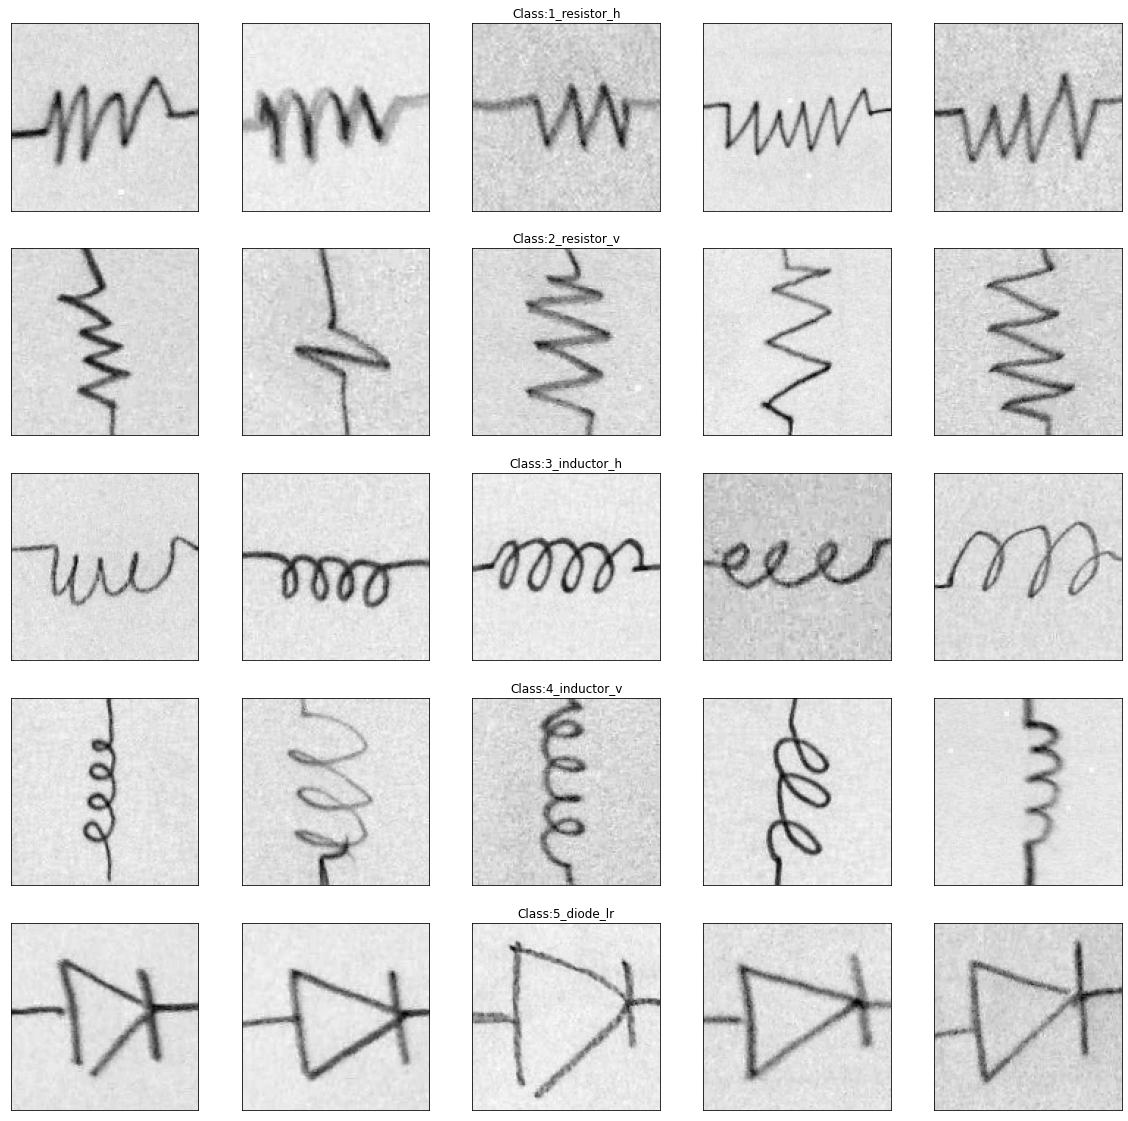

In [ ]:
_, axarr = plt.subplots(nrows=(classes-1), ncols=shots, figsize=(20, 20))

sample_keys = sorted(list(train_dataset.data.keys()))

for a in range(shots):
    for b in range(shots):
        temp_image = train_dataset.data[sample_keys[a]][b]
        # temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image = np.reshape(temp_image, (image_size, image_size))
        # temp_image = np.stack((temp_image[:, :]), axis=1)
        # temp_image *= 255

        if b == 2:
            axarr[a, b].set_title(f"Class:" + 
                train_dataset.class_names[int(sample_keys[a])])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()


## Build the model


In [ ]:
inputs = layers.Input(shape=(image_size, image_size, 1))

x = layers.Conv2D(32, 4, activation='relu', kernel_regularizer="l2")(inputs)

x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 4, activation='relu', kernel_regularizer="l2")(x)

x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 5, activation='relu', kernel_regularizer="l2")(x)

x = layers.Conv2D(64, 5, activation='relu', kernel_regularizer="l2")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 5, activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)

outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# x = conv_bn(inputs)
# x = conv_bn(x)
# x = conv_bn(x)
# x = layers.Flatten()(x)

# outputs = layers.Dense(classes, activation="softmax")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(metrics=['accuracy'], optimizer="adam")

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


## Train the model


In [ ]:
training = []
testing = []

train_loss =[]
val_loss = []

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size

    # Temporarily save the weights from the model.
    old_vars = model.get_weights()

    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_loss.append(loss[0])
    new_vars = model.get_weights()

    # # Perform SGD for the meta step.
    # for var in range(len(new_vars)):
    #     new_vars[var] = old_vars[var] + (
    #         (new_vars[var] - old_vars[var]) * cur_meta_step_size
    #     )

    # Perform Adam for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )

    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)

    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

            val_loss.append(loss[0])
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()

            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])

        if meta_iter % eval_interval == 0:
            print(
                f"batch {meta_iter}: \ttrain={accuracies[0]:.5f} \ttest={accuracies[1]:.5f} \tLoss: {train_loss[-1]}\t:\t{val_loss[-1]}"
            )


batch 0: 	train=0.50000 	test=0.33333 	Loss: 0.1880459040403366 : 1.7629059553146362
batch 10: 	train=0.50000 	test=0.16667 	Loss: 1.2190134525299072 : 1.8538919687271118
batch 20: 	train=0.66667 	test=0.33333 	Loss: 2.2673797607421875 : 1.7934706211090088
batch 30: 	train=0.50000 	test=0.16667 	Loss: 1.7887269258499146 : 1.4650616645812988
batch 40: 	train=0.33333 	test=0.50000 	Loss: 1.5497558116912842 : 0.22232791781425476
batch 50: 	train=0.16667 	test=0.50000 	Loss: 0.9618624448776245 : 1.7549694776535034
batch 60: 	train=0.50000 	test=0.33333 	Loss: 6.665777206420898 : 1.6910096406936646
batch 70: 	train=0.16667 	test=0.00000 	Loss: 0.4178132712841034 : 1.9031970500946045
batch 80: 	train=0.33333 	test=0.33333 	Loss: 0.04980163648724556 : 1.2180732488632202
batch 90: 	train=0.50000 	test=0.33333 	Loss: 0.5626794695854187 : 1.9592761993408203
batch 100: 	train=0.00000 	test=0.33333 	Loss: 0.5760401487350464 : 1.3108606338500977
batch 110: 	train=0.66667 	test=0.16667 	Loss: 0.7174

## Visualize Results


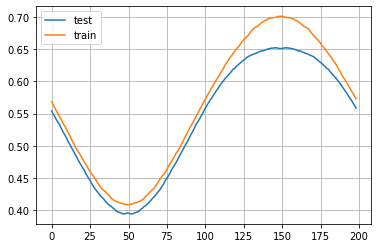

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()




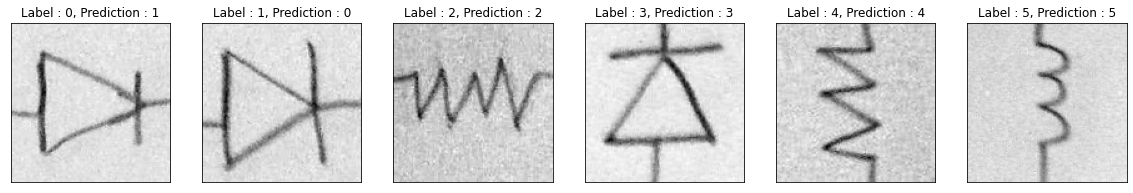

In [ ]:
train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)

for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=6, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(6), axarr):
    temp_image = test_images[i]
    # temp_image = np.stack((test_images[i, :, :]), axis=2)
    # temp_image *= 255
    # temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

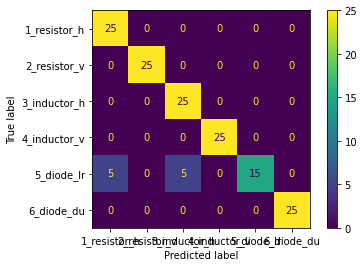

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

eval_batch_size = 100

val_ds = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes
)

for image, labels in val_ds:
    with tf.GradientTape() as tape:
        preds = model(image)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

test_preds = model.predict(val_ds)
# test_preds = tf.argmax(test_preds).numpy()
test_preds = np.argmax(model.predict(val_ds), axis=-1)


class_names = ['1_resistor_h', '2_resistor_v', '3_inductor_h', '4_inductor_v', '5_diode_lr', '6_diode_du']
labels = np.array([])
for x,y in val_ds:
    labels = np.concatenate([labels, np.array(y)])

# test_preds = np.argmax(model.predict(val_ds), axis=-1)

cm = tf.math.confusion_matrix(labels=labels, predictions=test_preds).numpy()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=class_names)

disp.plot()

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/25.jpeg',
    color_mode = "grayscale",
    target_size=(image_size,image_size))
input_arr = tf.keras.preprocessing.image.img_to_array(image)/255.0
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

pred =  np.argmax(model.predict(input_arr), axis=-1)
print(predictions)
# print(class_names[int(pred)])

[[0.1701163  0.1632468  0.16612634 0.14593448 0.14506894 0.20950712]]
